# IMDB Example

This example is based on an example from François Chollet's Deep Learning with Python that was also made available in the `3.5-classifying-movie-reviews.ipynb` notebook at

    https://github.com/fchollet/deep-learning-with-python-notebooks

We will leave explanation of the data set, problem motivation, network setup, etc., to the original source and just focus on the use of PyBT below.
In this first block you'll notice that the only PyBT-specific code are the few imports for the Trainer, wrapper, and a couple of policies.

**Setup note**: if you're running in the provided Docker image, you can install from source with `cd pybt && pip install -e .` in a Jupyter terminal.

In [1]:
from numpy.random import seed
seed(0xdeadbeef)

from tensorflow import set_random_seed
set_random_seed(0xdeadbeef)

from keras import layers, models
from keras.datasets import imdb
from keras.layers import Dense
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop
from keras.utils import to_categorical

import numpy as np

from pybt import Trainer
from pybt.model import KerasModelWrapper
from pybt.policy.ready import ReadyAfter
from pybt.policy.done import StopAfter
from pybt.helpers import notebook

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))

    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.

    return results

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

model = models.Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=0.001),
              loss=binary_crossentropy,
              metrics=['accuracy'])

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Now that we have the data prepped and a Keras model set up we're ready to train.
This is where you would usually call `model.fit(...)` to train for some epochs with our predefined hyperparameters.
But we are going to use PyBT to explore a space of hyperparameters instead.

The first step is to wrap our model.
We supply the compile parameters so that PyBT can recompile when exploring new hyperparameters.

In [2]:
m = KerasModelWrapper(model, optimizer=RMSprop(lr=0.001),
                      loss=binary_crossentropy,
                      metrics=['accuracy'])

The next step is to initialize a trainer with our wrapped model, policies, and fit and eval. args.
The policies are fairly straightforward.
The stopping criteria is set so that no model will train past 20 epochs.
The ready strategy is set so that a population member will only consider exploiting other models after evolving the current model by at least four epochs.
And the exploit strategy is set to use the truncation strategy discussed in the original PBT paper where models with performance in the bottom 20% of the population are swapped out for those in the top 20%.
(Note: you can explicitly set this strategy and those upper and lower bounds with `exploit_strategy=Truncation(upper=..., lower=...)`.)

The step and evaluation argument dictionaries should be fairly self-explanatory.
In particular, the `fit_args` and `eval_args` dicts get passed straight to the corresponding Keras model fit and evaluation methods.

In [3]:
t = Trainer(model=m,
    stopping_criteria=StopAfter(epochs=20),
    ready_strategy=ReadyAfter(4),
    step_args={'epochs_per_step': 2,
               'fit_args': {
                   'x': partial_x_train, 'y': partial_y_train,
                   'validation_data': (x_val, y_val),
                   'batch_size': 512}},
    eval_args={'x': x_val, 'y': y_val})

10000/10000 [==============================] - 1s 103us/step


After initializing the trainer we just call the train method to kick off the population-based training session.
When done, the best model and corresponding score are returned.
To be clear, *you get back a Keras model*, so it's ready to slot into the rest of your workflow right away!

In [4]:
model, score = t.train()

10000/10000 [==============================] - 1s 105us/step
Train on 15000 samples, validate on 10000 samples
Epoch 1/2
15000/15000 [==============================] - 2s 126us/step - loss: 0.5547 - acc: 0.7653 - val_loss: 0.4493 - val_acc: 0.8336
Epoch 2/2
10000/10000 [==============================] - 1s 107us/step
Train on 15000 samples, validate on 10000 samples
Epoch 3/4
15000/15000 [==============================] - 2s 117us/step - loss: 0.2586 - acc: 0.9219 - val_loss: 0.3200 - val_acc: 0.8735
Epoch 4/4
10000/10000 [==============================] - 1s 109us/step
Train on 15000 samples, validate on 10000 samples
Epoch 5/6
15000/15000 [==============================] - 2s 121us/step - loss: 0.1633 - acc: 0.9481 - val_loss: 0.2768 - val_acc: 0.8894
Epoch 6/6
10000/10000 [==============================] - 1s 109us/step
Train on 15000 samples, validate on 10000 samples
Epoch 7/8
15000/15000 [==============================] - 2s 123us/step - loss: 0.1101 - acc: 0.9661 - val_loss: 0.3

In [5]:
results = model.evaluate(x_test, y_test)

25000/25000 [==============================] - 3s 108us/step


In [6]:
results

[0.2945220180416107, 0.88268]

If you're interested in the details of the training session, you can get a nested record of all observations.

In [7]:
obs = t.observations()

This record has an entry for each member in the population, each with a list of observations per step.
At the step level, the observations will include hyperparameter settings like batch size and learning rate, the step number, epochs, and metric values.

The following shows observations for five steps of one model.
If you look closely, you can see that the batch size and learning rate were perturbed in the third step.

In [8]:
obs[8]

{'member': 'm6',
 'observations': [{'acc': [0.7652666665077209, 0.8955999998728434],
   'batch_size': [512, 512],
   'epochs': [0, 1],
   'learning_rate': [0.0010000000474974513, 0.0010000000474974513],
   'loss': [0.5546675678730011, 0.3580620555082957],
   't': 0,
   'val_acc': [0.8336000005722046, 0.8843999999046326],
   'val_loss': [0.44933319120407106, 0.3373098316669464]},
  {'acc': [0.9218666664441426, 0.9389333331108093],
   'batch_size': [512, 512],
   'epochs': [2, 3],
   'learning_rate': [0.0010000000474974513, 0.0010000000474974513],
   'loss': [0.25864165936311084, 0.19668395868142446],
   't': 1,
   'val_acc': [0.8734999999046326, 0.8876000001907348],
   'val_loss': [0.3199844402313232, 0.27975064787864684]},
  {'acc': [0.7288666632175446, 0.883066679596901],
   'batch_size': [534, 534],
   'epochs': [4, 5],
   'learning_rate': [0.023928562179207802, 0.023928562179207802],
   'loss': [1.3193703408837318, 0.305466581338644],
   't': 2,
   'val_acc': [0.8779000110983849, 0.

It's not difficult to flatten this nested structure into a table that is more useful for plotting but we've included some helper methods for doing that and getting some quick plots for a notebook like this one.

The following plots all training and validation accuracy measurements in one panel.
This is useful to get a sense for how different members of the population performed during the training session.
We can see that there was definitely some model swapping.

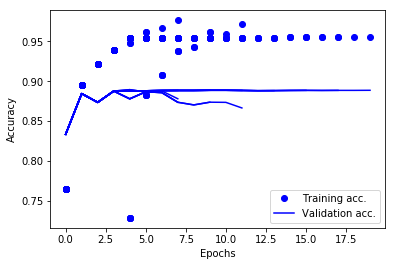

In [9]:
notebook.plot_members_acc(obs).show()

The next plot shows a plots the same accuracy measurements again, but this time there is a panel for each model.
The blank panel at the beginning is for the initial checkpoint of your model for which there are no observations.

Panels 1-4 show that the model was stepped four times (eight epochs in total) before the exploit strategy kicked in.
The reason this shows up as four panels, instead of just one panel with eight epocs is that PyBT checkpoints the model after each step.
This is done so that the population reflects intermediate points and not just the starting model.

Panel 5 shows that the system swapped in the intermediate model shown in panel 2, and panel 6 shows the results of perturbing the hyperparamters and running for another step.
Panels 7-9 continue to evolve this model until it's eventually swapped out for another model and hyperparameter setting that sticks.

One of the more interesting observations from this set of figures is that the PBT methodology prevents the exaggerated overfitting seen in the original notebook (referenced above).
In that work, the training accuracy quickly converges to 1.0 while validation accuracy quickly begins decreasing through the last 15 epochs.
In our case, we can see the training accuracy climbing on its way to 1.0 but then being stopped short (in panels 4 and 9) when it is swapped with another member.

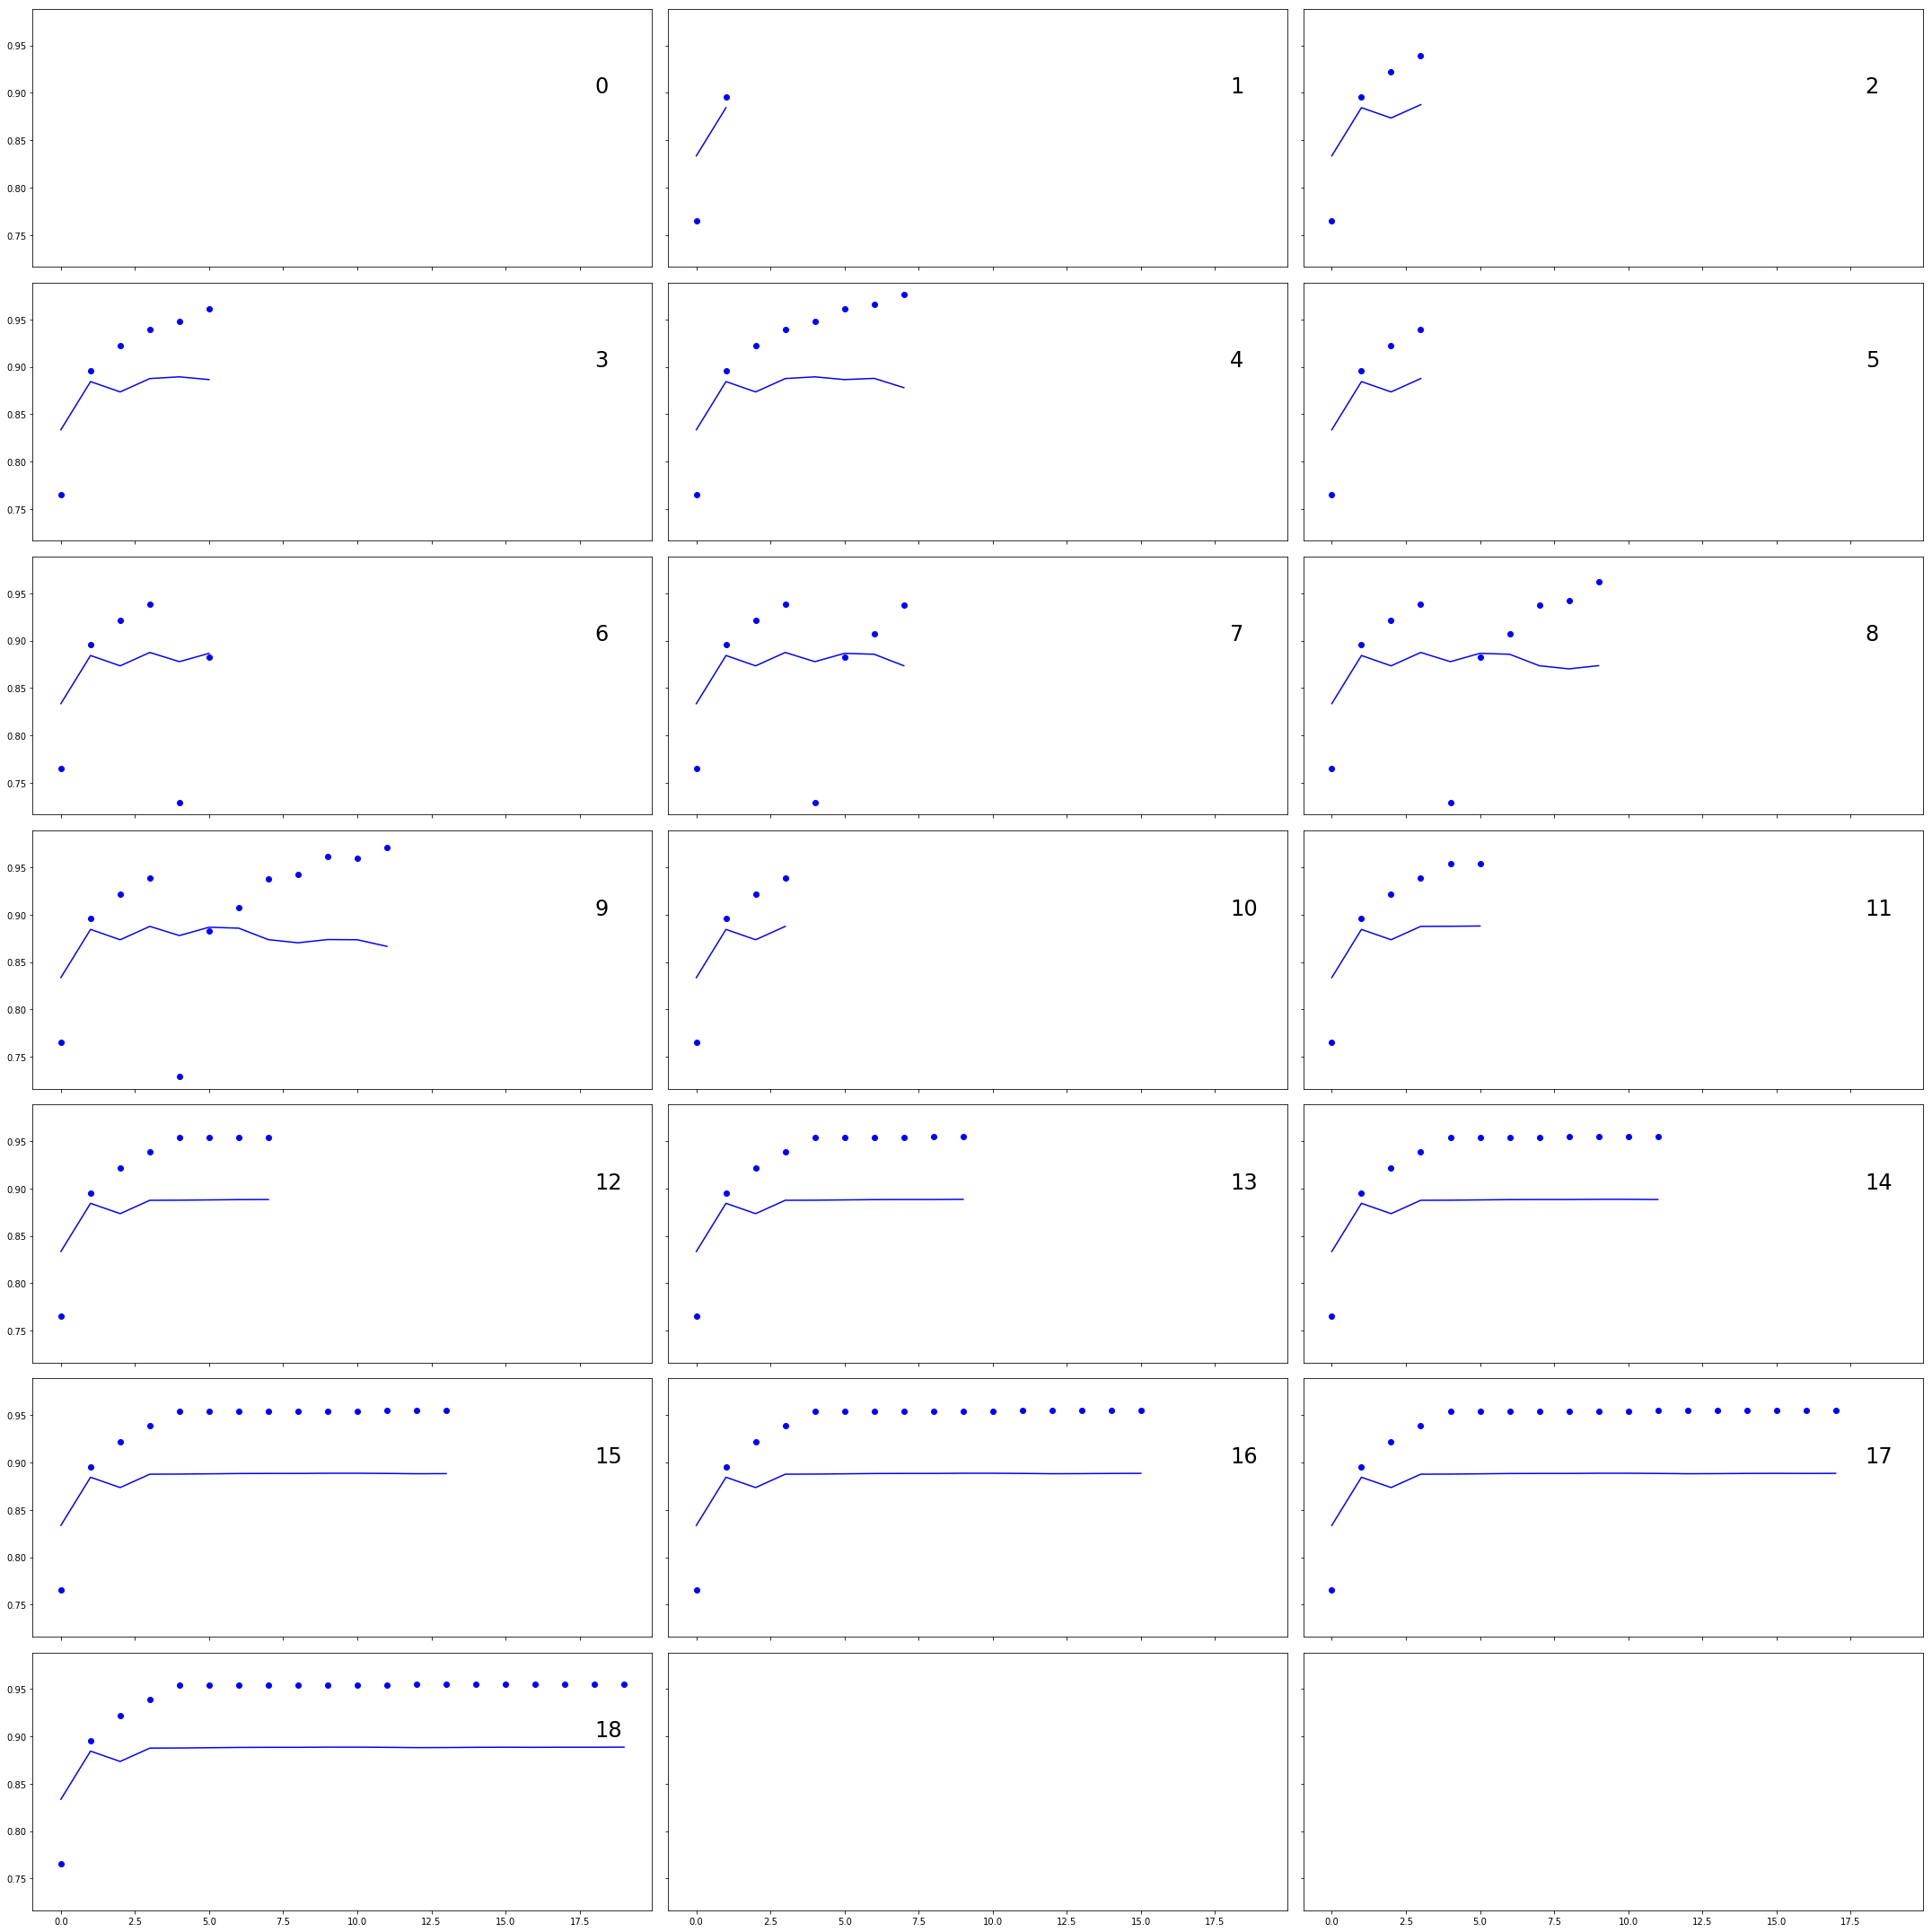

In [10]:
notebook.plot_all_acc(obs)

You can also get detailed views for any of the panels, and even switch to looking at the corresponding loss.

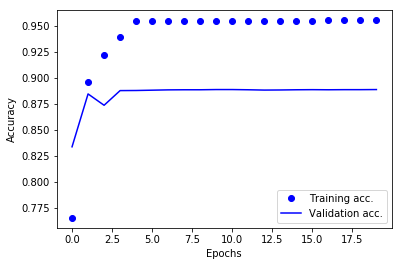

In [11]:
notebook.plot_member_acc(obs, 18).show()

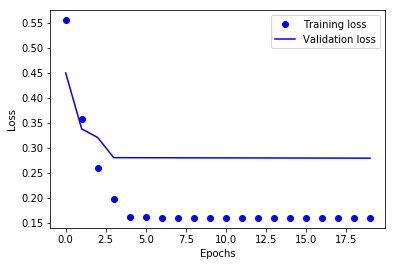

In [12]:
notebook.plot_member_loss(obs, 18).show()

Finally, you can also plot learning rate and batch size by epoch with the following methods.
There were clearly two times when the parameters were explored.
The first time both hyperparameters were bumped up and the second time they were bumped down.
Note: the rather low learning rate helps explain the flatlining of performance for the last model, too.

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

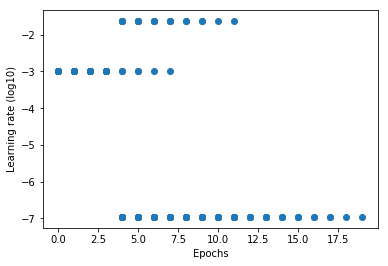

In [13]:
notebook.plot_learning_rate(obs)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

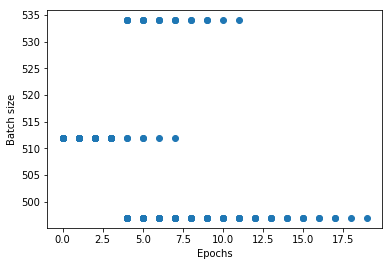

In [14]:
notebook.plot_batch_size(obs)